In [590]:
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import random
import string
import os
from subprocess import check_call

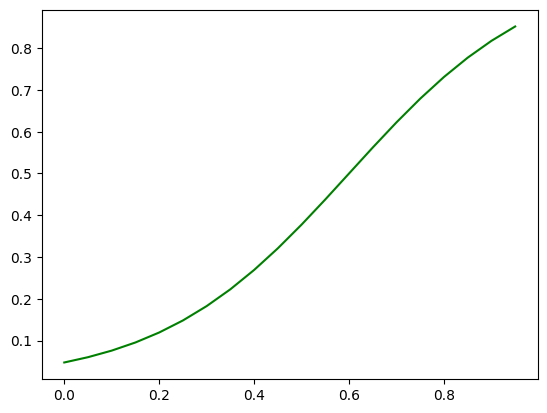

In [591]:
def test():
  x = np.arange(0, 1, 0.05)
  beta = 5
  alpha = 3
  y = np.exp(beta*x-alpha) / (1 + np.exp(beta*x-alpha))
  return plt.plot(x, y, 'g-')

test()

In [592]:
# Simulate phenotype. 
n_samples = 1000
y = scipy.stats.norm.rvs(size=n_samples)
y = y + np.abs(np.min(y)) + 0.05
y_norm = y / np.max(y)

In [593]:
# From the phenotype, simulate a few variants that are strongly associated.
n_signals = 2
alpha = 3
beta = 2.5

while 1:
  x = []
  for _ in range(n_signals):
    noise = scipy.stats.norm.rvs()
    tmp = np.exp(beta * y_norm + noise - alpha) / (1 + np.exp(beta*y_norm + noise - alpha))
    tmp = 2 - np.digitize(tmp, [0.33, 0.66])
    x.append(tmp)

  df = pd.DataFrame({"y": y, "x1": x[0], "x2": x[1]})
  fitobj1 = smf.ols("y ~ x1", data=df).fit()
  fitobj2 = smf.ols("y ~ x2", data=df).fit()

  r2 = np.corrcoef(df["x1"], df["x2"])[0,1]
  if not np.isnan(r2):
    break

/Users/welchr/.pyenv/versions/3.9.15/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/welchr/.pyenv/versions/3.9.15/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/welchr/.pyenv/versions/3.9.15/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/welchr/.pyenv/versions/3.9.15/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/welchr/.pyenv/versions/3.9.15/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/welchr/.pyenv/versions/3.9.15/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encount

In [594]:
np.corrcoef(df["x1"], df["x2"]) ** 2

array([[1.        , 0.85452429],
       [0.85452429, 1.        ]])

In [595]:
fitobj1.pvalues

Intercept    2.617006e-76
x1           1.575817e-35
dtype: float64

In [596]:
fitobj2.pvalues

Intercept    7.433205e-69
x2           1.599495e-32
dtype: float64

In [597]:
fitobj_both = smf.ols("y ~ x1 + x2", data=df).fit().pvalues
fitobj_both

Intercept    9.497730e-70
x1           1.064630e-04
x2           2.580949e-01
dtype: float64

In [598]:
def make_correlated_variant(variant, p):
  v = variant.copy()
  for i in range(len(v)):
    roll = np.random.random()
    if roll < (1 - p):
      v[i] = random.choice([0, 1, 2])

  return v

In [599]:
n_variants = 20
dosages = np.zeros((n_samples, n_variants))
#signal_pos = sorted(random.sample(range(1, n_variants + 1), 2))
signal_pos = [2, 12]

sigc = 0
for i in range(1, n_variants + 1):
  if i in signal_pos:
    dosages[:, i-1] = x[sigc]
    sigc += 1
    #sigc = min(sigc, n_signals - 1)
  else:
    #v = make_correlated_variant(x[sigc], np.random.random())
    v = np.random.randint(0, 3, size=n_samples)
    dosages[:, i-1] = v

In [600]:
print("Signal positions: ")
for p in signal_pos:
  print(p)

Signal positions: 
2
12


In [601]:
def write_vcf(dosages, positions, out):
  header = [x.strip() for x in """
    ##fileformat=VCFv4.2
    ##fileDate=20220217
    ##FORMAT=<ID=DS,Number=1,Type=Float,Description="Dosage from minimac2">
  """.strip().split("\n")]

  n_samples = dosages.shape[0]
  with open(out, "wt") as fp:
    for line in header:
      print(line, file=fp)

    print("\t".join("#CHROM POS ID REF ALT QUAL FILTER INFO FORMAT".split()) + "\t" + "\t".join([f"S{x+1}" for x in range(n_samples)]), file=fp)

    for col in range(dosages.shape[1]):
      #ref, alt = random.sample(["A", "C", "G", "T"], 2)
      ref, alt = ("A", "G")
      vid = f"1:{positions[col]}:{ref}:{alt}"
      fp.write(f"1\t{positions[col]}\t{vid}\t{ref}\t{alt}\t.\tPASS\t.\tDS\t")
      fp.write("\t".join((str(int(d)) for d in dosages[:,col])))
      fp.write("\n")

  gz_file = f"{out}.gz"
  if os.path.isfile(gz_file):
    check_call(f"rm -f {gz_file}", shell=True)

  check_call(f"bgzip {out}", shell=True)
  check_call(f"tabix {out}.gz", shell=True)

In [602]:
write_vcf(dosages, list(range(1, n_variants + 1)), "ld_range_test_s1.vcf")

In [603]:
noised_dosages = dosages.copy()
for j in range(noised_dosages.shape[1]):
  noised_dosages[np.random.randint(0, noised_dosages.shape[0], 50), j] = np.random.randint(0, 3, 50)

In [604]:
write_vcf(noised_dosages, list(range(1, n_variants + 1)), "ld_range_test_s2.vcf")

In [605]:
%%bash
gunzip -c ld_range_test_s1.vcf.gz | head -n 25 | cut -f 1-15

##fileformat=VCFv4.2
##fileDate=20220217
##FORMAT=<ID=DS,Number=1,Type=Float,Description="Dosage from minimac2">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	S1	S2	S3	S4	S5	S6
1	1	1:1:A:G	A	G	.	PASS	.	DS	0	0	0	2	2	2
1	2	1:2:A:G	A	G	.	PASS	.	DS	2	2	2	2	2	2
1	3	1:3:A:G	A	G	.	PASS	.	DS	1	0	2	2	2	2
1	4	1:4:A:G	A	G	.	PASS	.	DS	0	0	2	1	2	0
1	5	1:5:A:G	A	G	.	PASS	.	DS	1	2	0	2	1	0
1	6	1:6:A:G	A	G	.	PASS	.	DS	1	1	1	0	1	0
1	7	1:7:A:G	A	G	.	PASS	.	DS	0	0	0	2	2	1
1	8	1:8:A:G	A	G	.	PASS	.	DS	1	0	1	2	1	0
1	9	1:9:A:G	A	G	.	PASS	.	DS	1	1	2	1	1	1
1	10	1:10:A:G	A	G	.	PASS	.	DS	1	1	1	0	1	1
1	11	1:11:A:G	A	G	.	PASS	.	DS	0	1	1	0	1	1
1	12	1:12:A:G	A	G	.	PASS	.	DS	2	2	2	2	2	2
1	13	1:13:A:G	A	G	.	PASS	.	DS	0	1	1	1	0	0
1	14	1:14:A:G	A	G	.	PASS	.	DS	2	2	1	2	1	1
1	15	1:15:A:G	A	G	.	PASS	.	DS	0	0	0	1	2	1
1	16	1:16:A:G	A	G	.	PASS	.	DS	2	2	1	0	0	1
1	17	1:17:A:G	A	G	.	PASS	.	DS	0	1	1	2	1	1
1	18	1:18:A:G	A	G	.	PASS	.	DS	1	1	2	0	1	1
1	19	1:19:A:G	A	G	.	PASS	.	DS	2	0	0	2	1	0
1	20	1:20:A:G	A	G	.	PASS	.	DS	1	2	2	1	2	2


In [606]:
def rand_gene():
  return "".join(random.sample(string.ascii_uppercase, 4)) + "".join(random.sample(string.digits, 1))

In [607]:
def write_bed(gene, start, end, out, name=rand_gene()):
  n_samples = len(gene)
  with open(out, "wt") as fp:
    print("\t".join(["#chr", "start", "end", "gene_name"]) + "\t" + "\t".join((f"S{i+1}" for i in range(n_samples))), file=fp)
    fp.write(f"1\t{start}\t{end}\t{name}\t")
    fp.write("\t".join(f"{v:.3f}" for v in gene))
    fp.write("\n")

    # write dummy gene
    fp.write("1\t14\t16\tABCD1\t")
    fp.write("\t".join((f"{s:.3f}" for s in np.random.random(size=n_samples))))
    fp.write("\n")

    # write 2nd dummy gene so that AB1 script works!!!
    fp.write("1\t16\t19\tABCD2\t")
    fp.write("\t".join((f"{s:.3f}" for s in np.random.random(size=n_samples))))
    fp.write("\n")

  check_call(f"bgzip -c {out} > {out}.gz", shell=True)
  check_call(f"tabix {out}.gz", shell=True)

In [608]:
write_bed(y, 2, 13, "ld_range_test_s1.bed", "YAR1")

In [609]:
%%bash
gunzip -c ld_range_test_s1.bed.gz | head -n 25 | cut -f 1-15

#chr	start	end	gene_name	S1	S2	S3	S4	S5	S6	S7	S8	S9	S10	S11
1	2	13	YAR1	4.624	2.732	3.614	4.095	3.794	1.525	2.433	3.928	2.492	2.993	1.652
1	14	16	ABCD1	0.022	0.876	0.768	0.430	0.676	0.083	0.806	0.786	0.879	0.281	0.040
1	16	19	ABCD2	0.220	0.087	0.167	0.601	0.714	0.558	0.716	0.760	0.841	0.999	0.356


In [610]:
# Create a fake "study 2" bed file by noising some of the values
noised_y = y.copy()
noised_y[np.random.randint(0, len(y), 20)] = np.random.uniform(size=20)

In [611]:
write_bed(noised_y, 2, 13, "ld_range_test_s2.bed", "YAR1")

In [612]:
%%bash
gunzip -c ld_range_test_s2.bed.gz | head -n 25 | cut -f 1-15

#chr	start	end	gene_name	S1	S2	S3	S4	S5	S6	S7	S8	S9	S10	S11
1	2	13	YAR1	4.624	2.732	3.614	4.095	3.794	1.525	2.433	3.928	2.492	2.993	1.652
1	14	16	ABCD1	0.762	0.649	0.115	0.443	0.514	0.363	0.026	0.778	0.115	0.110	0.899
1	16	19	ABCD2	0.928	0.070	0.267	0.756	0.668	0.131	0.732	0.816	0.942	0.875	0.936
